Experiments relating to normalising the output of activation functions according to their mean and standard deviation characteristics, when the input is normally distributed (TODO: investigate other distributions)

**RESULTS**:

+ For some reason this does not work as well as expected on `xavier_normal`    initialisation, but works really well on the `default` pytorch weight initialisation.

    - this needs further investigation!

----------------------------

# Initialise

In [ ]:
%pip install pytorch_lightning

from functools import lru_cache
from typing import Sequence

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch import nn
import seaborn as sns
from torch.nn import functional as F
from tqdm import tqdm
import pytorch_lightning as pl


def iter_pairs(items):
    items = list(items)
    return list(zip(items[:-1], items[1:]))


In [ ]:
class SwishFunction(torch.autograd.Function):
    # The following implementation has lower memory usage

    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


def swish(t):
    return SwishFunction.apply(t)


class Swish(torch.nn.Module):
    def forward(self, tensor):
        return SwishFunction.apply(tensor)


In [ ]:
from itertools import chain

def color_plot_center(values, c=0):
    string = str_plot_center(values, center=c)
    pre, mid, aft = string[:2], string[2:-2], string[-2:]
    mid = ''.join(f'\033[91m{s}' if (v < c) else (f'\033[92m{s}' if (v > c) else f'{s}') for v, s in zip(values, mid)) + '\033[0m'
    return ''.join([pre, mid, aft])

def str_plot_center(values, center: float = None, min_radius=None):
    if len(values) == 0:
        line = ''
    else:
        line = str_plot(values, center=center, min_radius=min_radius, lines=1, min_is_zero=True)
    return f'[▸{line}◂]'

# prints a set of values as a ascii graph on a single line
def str_plot(values, center: float = None, min_radius=None, min=None, max=None, lines=1, min_is_zero=True):
    # check values
    bounded = False
    if (center is not None) or (min_radius is not None):
        assert (min is None) and (max is None)
    if (min is not None) and (max is not None):
        assert (center is None) and (min_radius is None)
        assert min < max
        bounded = True
    # consts
    symbols = ' ▁▂▃▄▅▆▇█'
    n = len(symbols)
    # get min and max
    if center is None:
        if bounded:
            m, M = min, max
        else:
            m, M = np.min(values), np.max(values)
        center, r = (m + M) / 2, M - m
    else:
        d = np.abs(center - np.min(values))
        D = np.abs(center - np.max(values))
        r = np.maximum(d, D)
    # adjust min radius
    if min_radius is not None:
        r = np.maximum(min_radius, r)
    r = np.maximum(r, 1e-20)
    # scale and clamp values
    values = np.clip((values-(center-r))/(2*r), 0, 1)
    # generate indices
    if min_is_zero:
        idx = 0 + np.int32(np.around(values * lines * (n-1)))
    else:
        idx = 1 + np.int32(np.around(values * lines * (n-2)))
    # normalise indices
    n_block_pad = idx // n
    n_space_pad = lines - (n_block_pad + 1)
    symbol_idx = idx % n
    # generate columns
    cols = [
        chain([' '] * ns, [symbols[i]], [symbols[-1]] * nb)
        for ns, i, nb in zip(n_space_pad, symbol_idx, n_block_pad)
    ]
    # generate rows
    return '\n'.join(''.join(row) for row in zip(*cols))

----------------------------
# Weights & Normalised Activations  [**IMPORTANT**]

## Weight Initializers


In [ ]:

_WEIGHT_INIT_MODES = {
    'default':         lambda x: None,
    'uniform':         torch.nn.init.uniform_,
    'normal':          torch.nn.init.normal_,
    'ones':            torch.nn.init.ones_,
    'zeros':           torch.nn.init.zeros_,
    'xavier_uniform':  torch.nn.init.xavier_uniform_,
    'xavier_normal':   torch.nn.init.xavier_normal_,
    'kaiming_uniform': torch.nn.init.kaiming_uniform_,
    'kaiming_normal':  torch.nn.init.kaiming_normal_,
    'orthogonal':      torch.nn.init.orthogonal_,
}

def weight_initializer(name):
    def decorator(fn):
        _WEIGHT_INIT_MODES_EXTRA[name] = fn
        return fn
    return decorator

# GENERAL INITIALISERS

def init_tensor(tensor: torch.Tensor, mode='xavier_normal'):
    if mode in _WEIGHT_INIT_MODES:
        _WEIGHT_INIT_MODES[mode](tensor)
    elif mode in _WEIGHT_INIT_MODES_EXTRA:
        _WEIGHT_INIT_MODES_EXTRA[mode](tensor)
    else:
        raise KeyError(f'invalid weight init mode: {repr(mode)}')
    return tensor

def _init_layer_weights(layer: nn.Module, mode='xavier_normal', verbose=False):
    # initialise common layers layer
    if isinstance(layer, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        init_tensor(layer.weight, mode=mode)
        init_tensor(layer.bias, mode='zeros')
    else:
        if verbose:
            print(f'warning, no init logic for layer of type: {type(layer)}')
    return layer

def init_weights(model: nn.Module, mode='xavier_normal', verbose=False):
    return model.apply(lambda m: _init_layer_weights(m, mode=mode, verbose=verbose))


## Custom Weight Initialisation

In [ ]:
_WEIGHT_INIT_MODES_EXTRA = {}

@weight_initializer('custom')
def _custom_weight_init(weight: torch.Tensor):
    assert weight.ndim == 2
    out, inp = weight.shape
    with torch.no_grad():
        weight.normal_(0., np.sqrt(1 / inp))

@weight_initializer('custom_alt')
def _custom_weight_init(weight: torch.Tensor):
    assert weight.ndim == 2
    out, inp = weight.shape
    with torch.no_grad():
        weight.normal_(0., 1.)
        weight -= weight.mean(dim=-1, keepdim=True)
        weight /= weight.std(dim=-1, unbiased=False, keepdim=True)
        weight *= np.sqrt(1 / inp)


## Normalized Activations  [**IMPORTANT**]

In [ ]:
def compute_activation_norms(activation_fn, num_samples=16384, device=None, dtype=torch.float32):
    with torch.no_grad():
        samples = torch.randn(num_samples, device=device, dtype=dtype)
        act = activation_fn(samples)
        return act.mean().item(), act.std(unbiased=False).item()

def cached_act_norm(activation_fn=None, num_samples=16384, device=None, dtype=torch.float32):
    def decorator(act_fn):
        from functools import wraps
        mean, std = compute_activation_norms(activation_fn=act_fn, num_samples=num_samples, device=device, dtype=dtype)
        @wraps(act_fn)
        def _act_norm(x):
            return (act_fn(x) - mean) / std
        if activation_fn is not None:
            _act_norm.__name__ = f'norm_{_act_norm.__name__}'
        return _act_norm
    return decorator(activation_fn) if (activation_fn is not None) else decorator


# make normalised activation functions
norm_tanh = cached_act_norm(torch.tanh)
norm_sigmoid = cached_act_norm(torch.sigmoid)
norm_relu = cached_act_norm(F.relu)
norm_relu6 = cached_act_norm(F.relu6)
norm_elu = cached_act_norm(F.elu)
norm_swish = cached_act_norm(swish)
norm_leaky_relu = cached_act_norm(F.leaky_relu)



ACTIVATIONS = {
    'identity': nn.Identity(),
    # builtin
    'tanh':       torch.tanh,
    'sigmoid':    torch.sigmoid,
    'relu':       F.relu,
    'relu6':      F.relu6,
    'leaky_relu': F.leaky_relu,
    'elu':        F.elu,
    'swish':      swish,
    # custom
    'norm_tanh':       norm_tanh,
    'norm_sigmoid':    norm_sigmoid,
    'norm_relu':       norm_relu,
    'norm_relu6':      norm_relu6,
    'norm_leaky_relu': norm_leaky_relu,
    'norm_elu':        norm_elu,
    'norm_swish':      norm_swish,
}

ACTIVATION_CLASSES = {
    'identity':   nn.Identity,
    # builtin
    'tanh':       nn.Tanh,
    'sigmoid':    nn.Sigmoid,
    'relu':       nn.ReLU,
    'relu6':      nn.ReLU6,
    'leaky_relu': nn.LeakyReLU,
    'elu':        nn.ELU,
    'swish':      Swish,
}


def activate(x, mode='norm_swish'):
    return ACTIVATIONS[mode](x)


def Activation(mode='norm_swish'):
    norm = False
    if mode.startswith('norm_'):
        norm = True
        mode = mode[len('norm_'):]
    activation = ACTIVATION_CLASSES[mode]()
    if norm:
        return NormActivation(activation, init_samples=1024, can_optimize=True)
    else:
        return NormActivation(activation, init_samples=None, can_optimize=False)



## Normalized Activations (Learned) [**IMPORTANT**]

In [ ]:
class NormActivation(nn.Module):

    def __init__(self, activation, init_samples: int = 1024, can_optimize=True):
        super().__init__()
        if init_samples is not None:
            mean, std = compute_activation_norms(activation, num_samples=init_samples, dtype=torch.float32)
        else:
            mean, std = 0, 1
        # can_optimize
        self._can_optimize = can_optimize
        # initialise values
        self._mean = nn.Parameter(torch.as_tensor(mean, dtype=torch.float32), requires_grad=False)
        self._std = nn.Parameter(torch.as_tensor(std, dtype=torch.float32), requires_grad=False)
        self._activation = activation
        # checks
        assert  self._mean.shape == ()
        assert  self._std.shape == ()
        assert isinstance(activation, nn.Module), f'activation is not an instance of nn.Module, got: {type(activation)}'
        # hooks
        self._forward_hook = None

    @property
    def can_optimize(self):
        return self._can_optimize

    @property
    def __name__(self):
        return f"norm_{getattr(self._activation, '__name__', self._activation)}"

    def __str__(self):
        return self.__name__

    def _set_forward_hook(self, hook):
        if hook is None:
            assert self._forward_hook is not None
        else:
            assert  self._forward_hook is None
        self._forward_hook = hook

    def _set_requires_grad(self, requires_grad: bool):
        if self.can_optimize:
            self._mean.requires_grad = requires_grad
            self._std.requires_grad = requires_grad

    def forward(self, x):
        y = (self._activation(x) - self._mean) / self._std
        if self._forward_hook is not None:
            if self.can_optimize:
                self._forward_hook(x, y)
            else:
                self._forward_hook(x.detach(), y.detach())
        return y

# recursive model helpers

def get_norm_layers(model: nn.Module):
    layers = []
    def _collect(m):
        if isinstance(m, NormActivation):
            layers.append(m)
    model.apply(_collect)
    return layers



----------------------------
# Activation Tests

## Activation Tracker

In [ ]:

# def stat(x, name: str = 'layer'):
#     return {'std': x.std().item(), 'mean': x.mean().item(), 'min': x.min().item(), 'max': x.max().item(), 'name': name}


# class SequentialStatTracker(nn.Module):

#     def __init__(self, layers, activation=None, normalize=True, include_pre_act=False):
#         super().__init__()
#         self._layers = nn.ModuleList(layers)
#         self._activation = activation
#         self._norm = normalize
#         self._include_pre_act = include_pre_act

#     def forward(self, x, include_pre_act=False):
#         stats = [stat(x, name='x0')]
#         for i, layer in enumerate(self._layers):
#             x = layer(x)
#             if self._include_pre_act:
#                 stats.append(stat(x, name=f'x{i+1}'))
#             if self._activation is not None:
#                 if self._norm:
#                     x = activate(x, self._activation)
#                 else:
#                     x = self._activation(x)
#                 stats.append(stat(x, name=f'x{i+1}_a'))
#         return x, stats


# def linear_layers(sizes: Sequence[int]):
#     return nn.ModuleList([nn.Linear(prev, next) for prev, next in iter_pairs(sizes)])



In [ ]:


# def sample_forward_random(sizes, title: str, batch_size=128, n_samples=100, activation=None, norm=False, include_pre_act=False):
#     # generate values
#     samples = []
#     for mode in tqdm([
#         'xavier_uniform',
#         'xavier_normal',
#         'custom',
#         # 'kaiming_normal',
#     ], desc=title):
#         for _ in range(n_samples):
#             model = SequentialStatTracker(layers=linear_layers(sizes), activation=activation, normalize=norm, include_pre_act=include_pre_act)
#             model = init_weights(model, mode=mode)
#             x = torch.randn(batch_size, sizes[0])
#             y, y_stats = model(x)
#             for y_stat in y_stats:
#                 y_stat['mode'] = mode
#             samples.extend(y_stats)

#     # aggregate
#     return [{'title': title, 'name': s['name'], 'mode': s['mode'], 'stat': k, 'value': s[k]} for s in samples for k in {'mean', 'std'}]

# def plot_activations(sizes, batch_size=128, n_samples=50, norm=False, include_pre_act=True):
#     suffix = ':norm' if norm else ''

#     samples = []
#     samples.extend(sample_forward_random(batch_size=batch_size, n_samples=n_samples, sizes=sizes, norm=norm, include_pre_act=include_pre_act, activation=None,      title='linear' + suffix))
#     # samples.extend(sample_forward_random(batch_size=batch_size, n_samples=n_samples, sizes=sizes, norm=norm, include_pre_act=include_pre_act, activation=nn.Sigmoid(), title='sigmoid' + suffix))
#     samples.extend(sample_forward_random(batch_size=batch_size, n_samples=n_samples, sizes=sizes, norm=norm, include_pre_act=include_pre_act, activation=nn.ReLU(), title='relu' + suffix))
#     # samples.extend(sample_forward_random(batch_size=batch_size, n_samples=n_samples, sizes=sizes, norm=norm, include_pre_act=include_pre_act, activation=nn.ReLU6(),   title='relu6' + suffix))
#     # samples.extend(sample_forward_random(batch_size=batch_size, n_samples=n_samples, sizes=sizes, norm=norm, include_pre_act=include_pre_act, activation=nn.ELU(),     title='elu' + suffix))
#     samples.extend(sample_forward_random(batch_size=batch_size, n_samples=n_samples, sizes=sizes, norm=norm, include_pre_act=include_pre_act, activation=Swish(),   title='swish' + suffix))

#     df = pd.DataFrame(samples).groupby(['title', 'mode', 'name', 'stat']).mean().reset_index()
#     df = df.sort_values(['name', 'title', 'mode', 'stat']).reset_index()

#     # plt.title(f'mean -- {sizes}')
#     # sns.lineplot(x="name", y="value", hue="title", style='mode', data=df[df['stat'] == 'mean'])
#     # plt.show()

#     plt.title(f'std -- {sizes}')
#     sns.lineplot(x="name", y="value", hue="title", style='mode', data=df[df['stat'] == 'std'])
#     plt.show()

#     return samples


# def __main__():
#     batch_size = 1024
#     n_samples = 100
#     sizes = [4, 16, 128, 16, 4]
#     plot_activations(batch_size=batch_size, n_samples=n_samples, sizes=sizes, norm=False)
#     plot_activations(batch_size=batch_size, n_samples=n_samples, sizes=sizes, norm=True)


# __main__()




## Extra Tests [**IMPORTANT**]


These tests examine the standard deviation and mean after different layers & activations in a fully linear neural network.

- Multiple networks with the same architecture are randomly initialised, and inputs are samples from a normal distribution.

- The goal is to acheive a state where the mean & std are 0 & 1 after every layer/ativation.

Interpreting the output:

- The little ascii graphs are indications of if the values are above or below the target values.
    + eg. "[▸▄▄▄▄▄▄▄▄▄▄▄◂]" is ideal for the std.
    + eg. "[▸▄▄▅▅▆█▅▄▄▃▃◂]" increases above 1, and then decreases below 1.

In [ ]:
def print_stats(stats, activation_names, stat_names=('mean', 'std'), mode='compact', title='unnamed'):
    assert stats.shape == (len(activation_names), len(stat_names)), f'invalid stats shape: {stats.shape}, must be: {(len(activation_names), len(stat_names))}'
    # print results
    if mode == 'verbose':
        print(f'[{title}]:')
        for name, stat in zip(activation_names, stats):
            print(f'  >>> {name:5s}: {mean:8.4f}, {std:8.4f}')
        print()
    elif mode == 'compact':
        try:
            means, stds = zip(*stats)
        except:
            means, stds = [], []
        print(
            f'[{title}]',
            '-',
            f'μ: {str_plot_center(means, center=0.0, min_radius=0.05)}',
            f'σ: {str_plot_center(stds, center=1.0, min_radius=0.5)}',
            '|',
            'μ: [' + ', '.join(f'{v:6.3f}' for v in means) + ']',
            'σ: [' + ', '.join(f'{v:6.3f}' for v in stds) + ']',
        )
    else:
        raise KeyError(f'invalid print stats mode: {repr(mode)}')


def hidden_sizes(start, mid, r=1):
    assert r >= 0
    down = np.int32(np.linspace(start, mid, r+1))[:-1]
    return (*down, mid, *down[::-1])


def identity(x):
    return x


In [ ]:
def sample_activations(sizes: tuple, init_mode='default', activation=None, display_mode='compact', batch_size=128, samples=512):
    activate = True
    if activation is None:
        activation = identity
        activate = False

    def a(lst, x):
        lst.append([x.mean(), x.std()])

    stats = []
    for _ in range(samples):
        sample = []
        # initialise
        ms = (
            init_weights(torch.nn.Linear(inp, out), mode=init_mode)
            for inp, out in iter_pairs(sizes)
        )
        # generate
        x = torch.randn(batch_size, sizes[0])
        a(sample, x)
        # feed forward
        for m in ms:
            x = m.forward(x)
            a(sample, x)
            x = activation(x)
        # save results
        stats.append(sample)

    # aggregate
    stats = torch.as_tensor(stats, dtype=torch.float32).mean(dim=0)
    names = ['inp', *(f'out{i:2d}' for i, _ in enumerate(iter_pairs(sizes)))]

    # print
    print_stats(
        stats, names,
        mode=display_mode,
        title=f'{init_mode:15s} | {str(getattr(activation, "__name__", activation)):15s}',
    )


for activation in [
    None,
    torch.sigmoid,
    norm_sigmoid,
    F.relu,
    norm_relu,
    torch.tanh,
    norm_tanh,
    swish,
    norm_swish,
]:
    print('='*100)
    print(getattr(activation, '__name__', activation))
    print('='*100)
    a, b = 64, 8
    sample_activations(hidden_sizes(a, b, 5), init_mode='default', activation=activation)
    sample_activations(hidden_sizes(a, b, 5), init_mode='default', activation=activation)
    sample_activations(hidden_sizes(a, b, 5), init_mode='custom', activation=activation)
    sample_activations(hidden_sizes(a, b, 5), init_mode='custom', activation=activation)
    sample_activations(hidden_sizes(a, b, 5), init_mode='xavier_normal', activation=activation)
    sample_activations(hidden_sizes(a, b, 5), init_mode='xavier_normal', activation=activation)


None
[default         | identity       ] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▄▂▁▁       ◂] | μ: [ 0.000,  0.000, -0.000, -0.000, -0.000,  0.000,  0.000, -0.000,  0.000, -0.000, -0.000] σ: [ 1.000,  0.577,  0.333,  0.192,  0.111,  0.064,  0.037,  0.021,  0.012,  0.007,  0.004]
[default         | identity       ] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▄▂▁▁       ◂] | μ: [ 0.000,  0.000, -0.000,  0.000,  0.000, -0.000, -0.000, -0.000,  0.000,  0.000,  0.000] σ: [ 1.000,  0.577,  0.333,  0.192,  0.111,  0.064,  0.037,  0.021,  0.012,  0.007,  0.004]
[custom          | identity       ] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄◂] | μ: [ 0.000, -0.000, -0.000, -0.000, -0.000, -0.000,  0.000, -0.000, -0.001,  0.001,  0.000] σ: [ 1.000,  1.001,  1.001,  1.000,  0.998,  0.995,  0.999,  0.996,  0.993,  0.989,  0.985]
[custom          | identity       ] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄◂] | μ: [-0.000,  0.000,  0.001, -0.001, -0.000,  0.000, -0.001,  0.001,  0.000,  0.001,  0.000] σ: [ 1.000,  1.000,  1.001,  1.003,  1.

## Extra Tests Learnt [**IMPORTANT**]

**IDEA!**

implement pre-tuning!

- neural network has normalisation parameters that are tuned by feeding the data through the network, and optimizing each so that the mean and standard deviation before and after each activation is 0 and 1.

- during this step no other parameters are optimized!

- might also take the gradient into account?

- separate parameters for gradient scaling on backward pass?

### Helper

In [ ]:
def ActivationMaker(mode='norm_swish'):
    return lambda i, inp, out: Activation(mode=mode)

def make_sequential_nn(sizes, activation, init_mode='default'):
    """
    activation can be a `str` or `Callable[[int, int, int], nn.Module]`
    """
    if isinstance(activation, str):
        activation = ActivationMaker(activation)
    # make fully connected layers
    linears = [nn.Linear(inp, out) for inp, out in iter_pairs(sizes)]
    # make activations
    if callable(activation):
        acts = [activation(i, inp, out) for i, (inp, out) in enumerate(iter_pairs(sizes[:-1]))]
    else:
        acts = list(activation)
    assert len(acts) == len(linears) - 1
    # interleave lists
    layers = [None] * (len(acts) + len(linears))
    layers[0::2] = linears
    layers[1::2] = acts
    # make model
    model = nn.Sequential(*layers)
    # initialise
    init_weights(model, mode=init_mode, verbose=False)
    return model

class NormHook(object):

    def __init__(self, model, requires_grad=False, include_unoptimizable=True):
        # get the norm layers & parameters
        self._norm_layers = get_norm_layers(model)
        self._requires_grad = requires_grad
        self._include_unoptimizable = include_unoptimizable
    
    def __enter__(self):
        # storage
        self._means = []
        self._stds = []
        # hook
        def mean_std_hook(x, y):
            assert len(self._means) < len(self._hooked_layers)
            assert len(self._stds) < len(self._hooked_layers)
            self._means.append(y.mean())
            self._stds.append(y.std(unbiased=False))
        # set requires_grad
        for layer in self._norm_layers:
            layer._set_requires_grad(self._requires_grad)
        # register hooks
        self._hooked_layers = []
        for layer in self._norm_layers:
            if layer.can_optimize or self._include_unoptimizable:
                layer._set_forward_hook(mean_std_hook)
                self._hooked_layers.append(layer)
        # return everything
        return self

    def __exit__(self, *args, **kwargs):
        assert not self._means
        assert not self._stds
        self._means = None
        self._stds = None
        # unset requires_grad
        for layer in self._norm_layers:
            layer._set_requires_grad(False)
        # unregister hooks
        for layer in self._hooked_layers:
            layer._set_forward_hook(None)
        self._hooked_layers = None

    @property
    def optimizable_layers(self):
        if self._requires_grad:
            return [l for l in self._hooked_layers if l.can_optimize]
        return []

    @property
    def optimizable_params(self):
        return nn.ModuleList(self.optimizable_layers).parameters()

    @property
    def has_optimizable(self):
        return len(self.optimizable_layers) > 0

    def end_step(self):
        assert len(self._means) == len(self._hooked_layers)
        assert len(self._stds) == len(self._hooked_layers)
        # exit early
        if len(self._hooked_layers) == 0:
            return torch.as_tensor([[], []], dtype=torch.float32)
        # stack the saved values
        means = torch.stack(self._means, dim=0)
        stds = torch.stack(self._stds, dim=0)
        # reset the storage
        self._means.clear()
        self._stds.clear()
        # return values
        return torch.stack([means, stds], dim=0)

    @property
    def means(self):
        return np.array([l._mean.item() for l in self._hooked_layers], dtype='float32')

    @property
    def stds(self):
        return np.array([l._std.item() for l in self._hooked_layers], dtype='float32')

    @property
    def means_stds(self):
        return np.array([self.means, self.stds])
    
    @property
    def values(self):
        return np.array([[l._mean.item(), l._std.item()] for l in self._hooked_layers], dtype='float32')


### Test

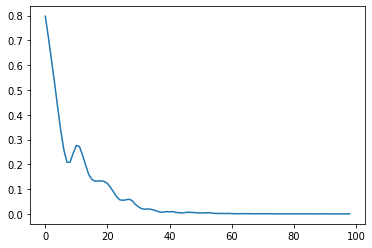

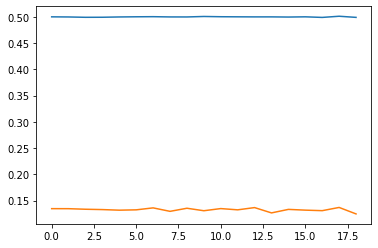

In [ ]:
def get_sampler(sampler='normal'):
    if isinstance(sampler, str):
        sampler = {
            'normal': lambda *shape: torch.randn(*shape, dtype=torch.float32),
            'uniform': lambda *shape: torch.rand(*shape, dtype=torch.float32),
            'suniform': lambda *shape: 2 * torch.rand(*shape, dtype=torch.float32) - 1
        }[sampler]
    else:
        assert callable(sampler)
    return sampler


def optimize_norm_layers(model, obs_shape, sampler='normal', batch_size=256, steps=100, lr=1e-1):
    sampler = get_sampler(sampler)
    # hook into the outputs of the layers
    # enabling gradients for the norms
    with NormHook(model, requires_grad=True, include_unoptimizable=True) as norm_hook:
        # exit early if model has no activation norm layers
        if not norm_hook.has_optimizable:
            return [], (np.array([]), np.array([]))
        # make the optimizer
        optimizer = torch.optim.Adamax(norm_hook.optimizable_params, lr=lr, eps=1e-5, weight_decay=1e-7)
        # optimize
        loss_hist = []
        for i in range(steps):
            x = sampler(batch_size, *obs_shape)
            # feed forward
            y = model.forward(x)
            means, stds = norm_hook.end_step()
            # compute loss
            loss_mean = ((0 - means) ** 2).mean()
            loss_std  = ((1 - stds) ** 2).mean()
            loss = loss_mean + loss_std
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # save values
            loss_hist.append(loss.item())

        return loss_hist, norm_hook.means_stds

sizes = hidden_sizes(128, 64, 10)
model = make_sequential_nn(sizes, 'norm_sigmoid')
loss_hist, (means, stds) = optimize_norm_layers(model, obs_shape=[sizes[0]], batch_size=256, lr=1e-2, steps=99, sampler='normal')

plt.plot(loss_hist)
plt.show()

plt.plot(means)
plt.plot(stds)
plt.show()

In [ ]:
def analyse_activations(model, obs_shape, sampler='normal', steps=100, title='', batch_size=512):
    sampler = get_sampler(sampler)
    # feed forward
    stats = []
    with torch.no_grad():
        with NormHook(model, requires_grad=False) as norm_hook:
            for i in range(steps):
                x = sampler(batch_size, *obs_shape)
                # feed forward
                y = model.forward(x)
                stat = norm_hook.end_step()
                # save results
                stats.append(stat)
            values = norm_hook.values
    # aggregate
    stats = torch.stack(stats, dim=0).mean(dim=0).T
    names = [f'out{i:2d}' for i in range(len(stats))]
    # print
    print_stats(stats, names, mode='compact', title=title)
    return values

def make_normalized_model(sizes, activation='norm_tanh', sampler='normal', init_mode='default', lr=1e-2, steps=100):
    shape = [sizes[0]]
    model = make_sequential_nn(sizes, activation, init_mode)
    title = f'{min(sizes):3d} {max(sizes):3d} {(len(sizes)-1)//2:3d} | {activation:18s} | {sampler:15s} | {init_mode:15s}'
    # get the activations
    before_values = analyse_activations(model, shape, sampler=sampler, title=f'{title} | PRE')
    optimize_norm_layers(model, shape, sampler=sampler, lr=lr, steps=steps)
    after_values = analyse_activations(model, shape, sampler=sampler, title=f'{title} | AFT')
    # get the differences
    dmeans, dstds = (before_values - after_values).T
    # colorize
    print(
        f'[{title} | DIF] - μ: {color_plot_center(dmeans)} σ: {color_plot_center(dstds)} |',
        'μ: [' + ', '.join(f'{v:6.3f}' for v in dmeans) + ']',
        'σ: [' + ', '.join(f'{v:6.3f}' for v in dstds) + ']\n',
    )
    return model

make_normalized_model(hidden_sizes(128, 64, 10), 'tanh');
make_normalized_model(hidden_sizes(128, 64, 10), 'norm_tanh');
make_normalized_model(hidden_sizes(128, 64, 50), 'norm_tanh');

[ 64 128  10 | tanh               | normal          | default         | PRE] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▁▁                ◂] | μ: [ 0.000,  0.000,  0.000, -0.000,  0.000, -0.000,  0.000, -0.000,  0.000,  0.000, -0.000, -0.000,  0.000,  0.000, -0.000, -0.000,  0.000,  0.000, -0.000] σ: [ 0.461,  0.251,  0.141,  0.080,  0.046,  0.026,  0.015,  0.009,  0.005,  0.003,  0.002,  0.001,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 64 128  10 | tanh               | normal          | default         | AFT] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▁▁                ◂] | μ: [-0.000,  0.000,  0.000, -0.000,  0.000, -0.000,  0.000,  0.000,  0.000, -0.000, -0.000,  0.000,  0.000, -0.000,  0.000,  0.000,  0.000,  0.000, -0.000] σ: [ 0.461,  0.251,  0.141,  0.080,  0.046,  0.026,  0.015,  0.009,  0.005,  0.003,  0.002,  0.001,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 64 128  10 | tanh               | normal          | default         | DIF] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] 

----------------------------
# Test Training Speeds

## setup

In [ ]:
import torchvision
import os

# modify the mnist dataset to only return observations, not labels
class CelebA(torchvision.datasets.CelebA, Sequence):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        return img


# modify the mnist dataset to only return observations, not labels
class MNIST(torchvision.datasets.MNIST, Sequence):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        return img


class MnistDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 128, num_workers=os.cpu_count(), shuffle=True, normalise=False):
        super().__init__()
        self._batch_size = batch_size
        self._num_workers = num_workers
        self._shuffle = shuffle
        self._normalise = normalise

    def setup(self, stage = None):
        if self._normalise:
            transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=0.5, std=0.5)
            ])
        else:
            transform = torchvision.transforms.ToTensor()
        # get datasets
        self._data_trn = MNIST(root='data', transform=transform, train=True, download=True)
        self._data_val = MNIST(root='data', transform=transform, train=False, download=False)
        return self

    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self._data_trn, num_workers=self._num_workers, batch_size=self._batch_size, shuffle=self._shuffle)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self._data_val, num_workers=self._num_workers, batch_size=self._batch_size, shuffle=self._shuffle)



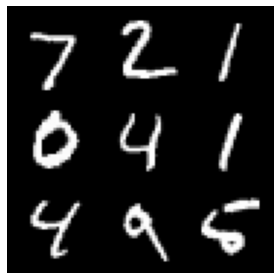

In [ ]:

from IPython.display import clear_output

for img_batch in MnistDataModule(batch_size=9, shuffle=False, num_workers=0).setup().val_dataloader():
    break

def plot_batch(*batches: torch.Tensor, clip=False, mean=None, std=None):
    fig, axs = plt.subplots(1, len(batches), squeeze=False)
    for batch, ax in zip(batches, axs.reshape(-1)):
        assert batch.ndim == 4
        assert batch.dtype == torch.float32
        if std is not None:
            batch = batch * std
        if mean is not None:
            batch = batch + mean
        if clip:
            batch = torch.clip(batch, 0, 1)
        image = torch.moveaxis(torchvision.utils.make_grid(batch, nrow=3), 0, -1)
        ax.imshow(image)
        ax.set_axis_off()
    fig.tight_layout()
    plt.show()

plot_batch(img_batch)

## tester

### - helper

In [ ]:
import logging

# hide GPU/CPU message
pl.utilities.distributed.log.setLevel(logging.ERROR)

class SimpleSystem(pl.LightningModule):
    def __init__(
        self,
        model_sizes: tuple = (28*28, 128, 32, 128, 28*28),
        model_activation: str = 'tanh',
        model_init_mode: str = 'xavier_normal',
        # data handling
        normalize_input: bool = True,
        unnormalize_output: bool = True,
        # optimizer
        lr=1e-3,
        loss='mse',
        # normalising
        norm_lr=5e-3,
        norm_sampler='normal',
        norm_steps=200,
    ):
        super().__init__()
        self.save_hyperparameters()
        # init model
        self._model = make_normalized_model(model_sizes, activation=model_activation, sampler=norm_sampler, init_mode=model_init_mode, lr=norm_lr, steps=norm_steps)
        # get loss
        self._loss_fn = {
            'mse': F.mse_loss,
            'bce': F.binary_cross_entropy,
            'bce_l': F.binary_cross_entropy_with_logits,
        }[self.hparams.loss]
    
    def forward(self, x):
        (B, *shape) = x.shape
        # do normalize
        if self.hparams.normalize_input:
            x = (x - 0.5) / 0.5
        x = x.reshape(B, -1)
        # feed forward
        x = self._model(x)
        # unnormalize
        x = x.reshape(B, *shape)
        if self.hparams.unnormalize_output:
            x = (x * 0.5) + 0.5
        # get values
        return x

    def training_step(self, batch, batch_idx):
        y = self.forward(batch)
        return self._loss_fn(y, batch, reduction='mean')

    def configure_optimizers(self):
        # return torch.optim.Adadelta(self.parameters(), lr=self.hparams.lr)
        return torch.optim.Adamax(self.parameters(), lr=self.hparams.lr)
        # return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

def run(
    model_activation: str = 'tanh',
    model_init_mode: str = 'xavier_normal',
    model_hidden_sizes: tuple = (128, 32, 128),
    # data handling
    normalize_input: bool = True,
    unnormalize_output: bool = True,
    # optimizer
    lr=1e-3,
    loss='mse',
    # normalising
    norm_lr=5e-3,
    norm_sampler='normal',
    norm_steps=200,
    # training
    epochs=1,
    batch_size=128,
):
    print('='*100)
    print(model_activation, model_init_mode, lr, batch_size, epochs)
    print('='*100)
    # get data and vis batch
    data = MnistDataModule(batch_size=batch_size, normalise=False)
    for img_batch in MnistDataModule(batch_size=9, normalise=False, shuffle=False, num_workers=0).setup().val_dataloader():
        break
    # create system
    model = SimpleSystem(
        model_sizes=[28*28, *model_hidden_sizes, 28*28],
        model_activation=model_activation,
        model_init_mode=model_init_mode,
        normalize_input=normalize_input,
        unnormalize_output=unnormalize_output,
        lr=lr,
        loss=loss,
        norm_lr=norm_lr,
        norm_sampler=norm_sampler,
        norm_steps=norm_steps,
    )
    # create trainer
    trainer = pl.Trainer(checkpoint_callback=False, logger=False, max_epochs=epochs, weights_summary=None)
    trainer.fit(model, data,)
    # visualise
    # clear_output(wait=True)
    plot_batch(img_batch, model.forward(img_batch.to(model.device)))
    print('='*100)

### - Run

tanh default 0.001 128 3
[ 32 784  11 | tanh               | normal          | default         | PRE] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▁▁                  ◂] | μ: [ 0.000,  0.000, -0.000, -0.000,  0.000, -0.000, -0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000, -0.000, -0.000,  0.000,  0.000, -0.000, -0.000, -0.000] σ: [ 0.460,  0.250,  0.142,  0.081,  0.047,  0.027,  0.016,  0.009,  0.006,  0.003,  0.002,  0.001,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784  11 | tanh               | normal          | default         | AFT] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▁▁                  ◂] | μ: [ 0.000,  0.000, -0.000,  0.000, -0.000,  0.000, -0.000,  0.000,  0.000, -0.000,  0.000, -0.000, -0.000,  0.000,  0.000,  0.000,  0.000, -0.000,  0.000,  0.000,  0.000] σ: [ 0.460,  0.251,  0.142,  0.081,  0.047,  0.027,  0.016,  0.009,  0.006,  0.003,  0.002,  0.001,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784 

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


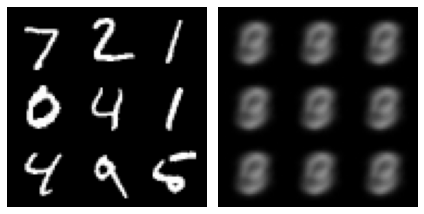

In [ ]:


run('tanh', 'default', hidden_sizes(128, 32, r=10), batch_size=128, lr=1e-3, epochs=3, loss='mse');

tanh custom 0.003 64 1
[ 32 784  11 | tanh               | normal          | custom          | PRE] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▂▁▁▁▁▁▁             ◂] | μ: [ 0.000,  0.000, -0.000, -0.000, -0.000, -0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000, -0.000, -0.000,  0.000, -0.000,  0.000, -0.000, -0.000,  0.000,  0.000] σ: [ 0.627,  0.486,  0.409,  0.356,  0.325,  0.294,  0.272,  0.263,  0.236,  0.239,  0.206,  0.192,  0.183,  0.176,  0.164,  0.159,  0.149,  0.142,  0.139,  0.142,  0.137]
[ 32 784  11 | tanh               | normal          | custom          | AFT] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▂▁▁▁▁▁▁             ◂] | μ: [-0.000,  0.000, -0.000, -0.000, -0.000, -0.000, -0.000,  0.000, -0.000,  0.000, -0.000,  0.000, -0.000,  0.000,  0.000,  0.000, -0.000,  0.000,  0.000, -0.000, -0.000] σ: [ 0.627,  0.486,  0.409,  0.356,  0.325,  0.293,  0.271,  0.263,  0.236,  0.239,  0.206,  0.192,  0.184,  0.176,  0.164,  0.159,  0.149,  0.142,  0.139,  0.142,  0.137]
[ 32 784  1

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


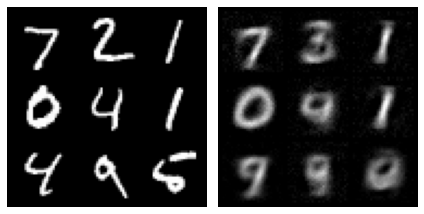

norm_tanh custom 0.003 64 1
[ 32 784  11 | norm_tanh          | normal          | custom          | PRE] - μ: [▸▇▃▃▅ ▄▇▂▇▄▅▁▄▁▄▅▁▆▅▆▄◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] | μ: [ 0.041, -0.012, -0.022,  0.014, -0.061,  0.003,  0.044, -0.027,  0.041,  0.007,  0.015, -0.042,  0.005, -0.049,  0.007,  0.019, -0.039,  0.030,  0.018,  0.035, -0.005] σ: [ 1.002,  0.996,  0.995,  0.988,  0.993,  0.994,  1.017,  0.989,  0.991,  1.009,  0.985,  0.985,  0.980,  0.985,  0.999,  1.001,  1.005,  1.003,  0.998,  1.014,  1.027]
[ 32 784  11 | norm_tanh          | normal          | custom          | AFT] - μ: [▸▄▄▄▄▄▄▄▃▃▄▃▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] | μ: [-0.001,  0.003, -0.004, -0.001,  0.001,  0.006,  0.001, -0.008, -0.008, -0.000, -0.010,  0.004, -0.005, -0.003,  0.004,  0.000, -0.001, -0.001,  0.003, -0.002,  0.002] σ: [ 1.004,  1.004,  1.002,  1.000,  0.999,  0.997,  0.999,  0.998,  0.997,  0.997,  0.997,  0.999,  1.001,  1.003,  1.001,  1.002,  1.003,  1.001,  1.001,  0.999,  0.999]
[ 32 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


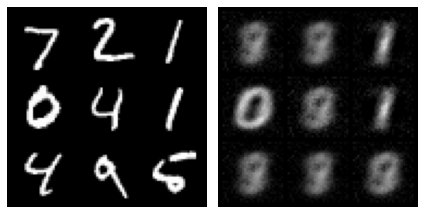

In [ ]:
run('tanh',      'custom', hidden_sizes(128, 32, r=10), batch_size=64, lr=3e-3, epochs=1, loss='mse');
run('norm_tanh', 'custom', hidden_sizes(128, 32, r=10), batch_size=64, lr=3e-3, epochs=1, loss='mse');

## tests

tanh default 0.001 64 2
[ 32 784  11 | tanh               | normal          | default         | PRE] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▁▁                  ◂] | μ: [-0.000,  0.000,  0.000, -0.000,  0.000,  0.000, -0.000,  0.000, -0.000, -0.000, -0.000,  0.000, -0.000, -0.000,  0.000, -0.000, -0.000,  0.000,  0.000, -0.000, -0.000] σ: [ 0.460,  0.250,  0.141,  0.081,  0.047,  0.026,  0.015,  0.009,  0.005,  0.003,  0.002,  0.001,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784  11 | tanh               | normal          | default         | AFT] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▁▁                  ◂] | μ: [ 0.000, -0.000, -0.000, -0.000,  0.000,  0.000, -0.000,  0.000, -0.000, -0.000, -0.000, -0.000, -0.000, -0.000,  0.000, -0.000, -0.000, -0.000,  0.000,  0.000,  0.000] σ: [ 0.460,  0.250,  0.141,  0.081,  0.047,  0.026,  0.015,  0.009,  0.005,  0.003,  0.002,  0.001,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784  

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


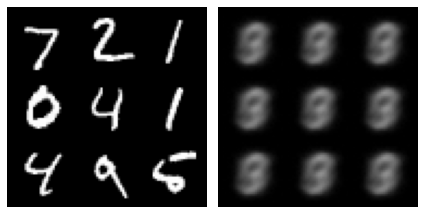

norm_tanh default 0.001 64 2
[ 32 784  11 | norm_tanh          | normal          | default         | PRE] - μ: [▸▅▃▄▄▄▃▄▆▅▃█▇▅▇▂▄▃▃▃▅▂◂] σ: [▸▃▂▂▁▁▁▁▁▁            ◂] | μ: [ 0.014, -0.021,  0.005, -0.003,  0.002, -0.024, -0.004,  0.035,  0.014, -0.013,  0.082,  0.065,  0.012,  0.069, -0.050,  0.008, -0.027, -0.019, -0.026,  0.010, -0.032] σ: [ 0.754,  0.605,  0.493,  0.418,  0.370,  0.331,  0.281,  0.235,  0.204,  0.182,  0.160,  0.165,  0.156,  0.135,  0.145,  0.143,  0.128,  0.114,  0.106,  0.098,  0.087]
[ 32 784  11 | norm_tanh          | normal          | default         | AFT] - μ: [▸▄▄▄▄▃▄▃▅▄▃▃▇█▄▅▅▄▄▄▄▄◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] | μ: [ 0.004, -0.004, -0.001, -0.005, -0.012, -0.002, -0.022,  0.014, -0.002, -0.018, -0.013,  0.057,  0.086, -0.006,  0.012,  0.016, -0.007,  0.004, -0.001, -0.000,  0.003] σ: [ 1.001,  1.012,  0.991,  0.992,  1.002,  1.005,  0.999,  0.992,  0.997,  1.003,  1.011,  0.990,  0.988,  1.005,  1.000,  0.990,  0.996,  1.006,  1.000,  0.995,  1.001]
[ 32 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


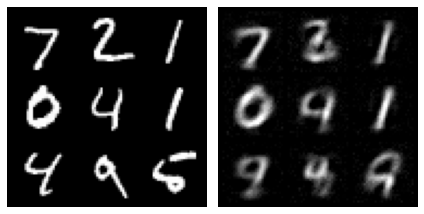

swish default 0.001 64 2
[ 32 784  11 | swish              | normal          | default         | PRE] - μ: [▸█▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▁                    ◂] | μ: [ 0.077,  0.005,  0.001,  0.000, -0.000,  0.000, -0.000,  0.000,  0.000,  0.000, -0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000, -0.000, -0.000] σ: [ 0.306,  0.092,  0.027,  0.008,  0.002,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784  11 | swish              | normal          | default         | AFT] - μ: [▸█▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▁                    ◂] | μ: [ 0.077,  0.005,  0.001,  0.000, -0.000,  0.000, -0.000,  0.000,  0.000,  0.000, -0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000, -0.000, -0.000] σ: [ 0.306,  0.092,  0.027,  0.008,  0.002,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  if sys.path[0] == '':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


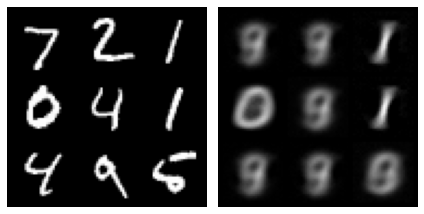

norm_swish default 0.001 64 2
[ 32 784  11 | norm_swish         | normal          | default         | PRE] - μ: [▸▂▁▁▁▁▁ ▁▁▁▁   ▁▁▁▁▁▁▁◂] σ: [▸▂▁                   ◂] | μ: [-0.218, -0.283, -0.342, -0.355, -0.286, -0.340, -0.374, -0.334, -0.299, -0.287, -0.306, -0.396, -0.425, -0.382, -0.302, -0.271, -0.319, -0.342, -0.321, -0.315, -0.361] σ: [ 0.534,  0.307,  0.225,  0.238,  0.237,  0.175,  0.180,  0.242,  0.203,  0.201,  0.206,  0.183,  0.242,  0.194,  0.209,  0.226,  0.200,  0.198,  0.186,  0.202,  0.186]
[ 32 784  11 | norm_swish         | normal          | default         | AFT] - μ: [▸▃▃▂▂▄▅▁ ▂▄▃▃▅▁▁▂▃▄▃▄▄◂] σ: [▸▅▅▄▃▅▄▄▃▄▅▄▄▅▄▄▄▄▅▄▄▄◂] | μ: [-0.061, -0.134, -0.213, -0.248,  0.048,  0.105, -0.305, -0.426, -0.262, -0.042, -0.089, -0.078,  0.094, -0.363, -0.266, -0.177, -0.065, -0.015, -0.116, -0.006, -0.005] σ: [ 1.120,  1.168,  1.034,  0.901,  1.103,  0.983,  0.953,  0.904,  1.054,  1.082,  0.979,  0.978,  1.176,  0.978,  0.991,  0.973,  1.004,  1.167,  0.957,  0.938,  1.021]
[ 32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


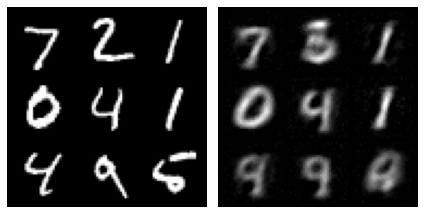

relu default 0.001 64 2
[ 32 784  11 | relu               | normal          | default         | PRE] - μ: [▸█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▁▁                   ◂] | μ: [ 0.230,  0.095,  0.040,  0.014,  0.005,  0.002,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000] σ: [ 0.338,  0.137,  0.056,  0.022,  0.008,  0.003,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784  11 | relu               | normal          | default         | AFT] - μ: [▸█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▁▁                   ◂] | μ: [ 0.231,  0.095,  0.040,  0.014,  0.005,  0.002,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000] σ: [ 0.338,  0.137,  0.056,  0.022,  0.008,  0.003,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


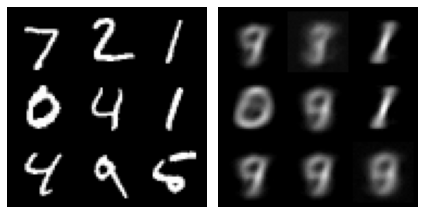

norm_relu default 0.001 64 2
[ 32 784  11 | norm_relu          | normal          | default         | PRE] - μ: [▸▂▁ ▁▁  ▁ ▁▁   ▁▁ ▁▁▁ ◂] σ: [▸▂▁ ▁   ▁ ▁▁  ▁▁▁▁▁▁▁ ◂] | μ: [-0.280, -0.424, -0.471, -0.431, -0.429, -0.525, -0.502, -0.353, -0.465, -0.462, -0.443, -0.476, -0.526, -0.463, -0.452, -0.430, -0.484, -0.461, -0.446, -0.437, -0.529] σ: [ 0.564,  0.365,  0.302,  0.349,  0.320,  0.229,  0.247,  0.418,  0.290,  0.366,  0.332,  0.262,  0.274,  0.391,  0.346,  0.333,  0.342,  0.329,  0.341,  0.354,  0.266]
[ 32 784  11 | norm_relu          | normal          | default         | AFT] - μ: [▸▄▄ ▄▄▃▃▃▂▃▄▄▃▃▃▃▃▃▃▄▃◂] σ: [▸▄▅▄▄▄▄▄▅▄▄▄▃▃▄▄▃▃▃▃▃▃◂] | μ: [ 0.003, -0.029, -0.345, -0.035, -0.027, -0.095, -0.053, -0.071, -0.180, -0.109, -0.038, -0.030, -0.105, -0.050, -0.059, -0.129, -0.055, -0.058, -0.049, -0.043, -0.051] σ: [ 1.047,  1.182,  0.994,  0.986,  0.967,  0.978,  0.957,  1.101,  0.952,  0.947,  0.966,  0.931,  0.924,  0.951,  1.032,  0.888,  0.888,  0.872,  0.860,  0.909,  0.872]
[ 32 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


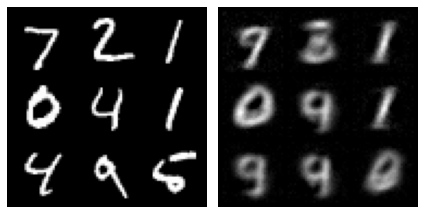

tanh custom 0.001 64 2
[ 32 784  11 | tanh               | normal          | custom          | PRE] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▂▁▁▁▁▁              ◂] | μ: [-0.000, -0.000,  0.000,  0.000,  0.000,  0.000,  0.000, -0.000, -0.000, -0.000, -0.000, -0.000,  0.000, -0.000, -0.000,  0.000, -0.000, -0.000,  0.000, -0.000, -0.000] σ: [ 0.628,  0.484,  0.404,  0.353,  0.315,  0.294,  0.274,  0.257,  0.244,  0.226,  0.222,  0.202,  0.194,  0.198,  0.194,  0.202,  0.190,  0.173,  0.162,  0.166,  0.161]
[ 32 784  11 | tanh               | normal          | custom          | AFT] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▂▁▁▁▁▁              ◂] | μ: [ 0.000, -0.000,  0.000, -0.000, -0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000, -0.000,  0.000,  0.000, -0.000,  0.000,  0.000, -0.000,  0.000,  0.000] σ: [ 0.628,  0.484,  0.404,  0.352,  0.315,  0.294,  0.273,  0.257,  0.244,  0.226,  0.222,  0.201,  0.194,  0.197,  0.194,  0.201,  0.190,  0.173,  0.162,  0.166,  0.161]
[ 32 784  1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


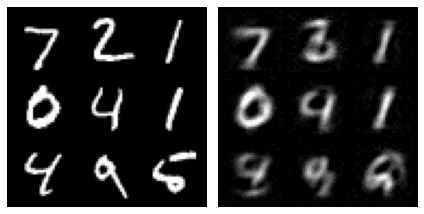

norm_tanh custom 0.001 64 2
[ 32 784  11 | norm_tanh          | normal          | custom          | PRE] - μ: [▸▇▆█▅▆▂ ▄▂▂▄ ▆▃▃▁█▅█▅▅◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] | μ: [ 0.052,  0.026,  0.058,  0.021,  0.026, -0.024, -0.059,  0.001, -0.029, -0.024, -0.001, -0.061,  0.031, -0.018, -0.020, -0.046,  0.063,  0.014,  0.062,  0.011,  0.016] σ: [ 1.012,  1.033,  1.002,  0.985,  1.011,  1.016,  0.985,  1.030,  1.023,  0.991,  0.981,  1.004,  1.009,  0.996,  0.995,  0.992,  0.991,  1.019,  1.022,  0.970,  0.981]
[ 32 784  11 | norm_tanh          | normal          | custom          | AFT] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] | μ: [-0.001,  0.000,  0.001,  0.001, -0.001,  0.004,  0.003, -0.000,  0.002, -0.001, -0.003,  0.005, -0.000,  0.001,  0.002, -0.001,  0.001, -0.000, -0.006, -0.003,  0.003] σ: [ 1.000,  1.000,  1.000,  0.999,  0.998,  0.999,  1.001,  1.000,  1.001,  1.001,  1.002,  1.002,  1.003,  1.002,  1.001,  1.000,  1.002,  1.001,  0.999,  1.000,  1.002]
[ 32 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


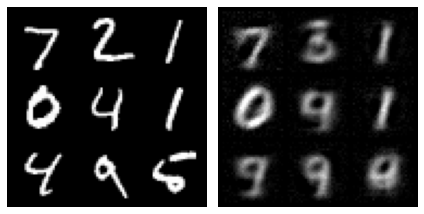

swish custom 0.001 64 2
[ 32 784  11 | swish              | normal          | custom          | PRE] - μ: [▸█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▁▁                  ◂] | μ: [ 0.206,  0.082,  0.033,  0.010,  0.001,  0.001, -0.000,  0.000,  0.000, -0.000,  0.000, -0.000,  0.000,  0.000, -0.000, -0.000, -0.000,  0.000,  0.000, -0.000,  0.000] σ: [ 0.559,  0.314,  0.168,  0.086,  0.043,  0.022,  0.011,  0.006,  0.003,  0.001,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784  11 | swish              | normal          | custom          | AFT] - μ: [▸█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▁▁                  ◂] | μ: [ 0.206,  0.081,  0.033,  0.010,  0.001,  0.001, -0.000,  0.000,  0.000, -0.000,  0.000, -0.000,  0.000,  0.000, -0.000, -0.000, -0.000,  0.000,  0.000, -0.000,  0.000] σ: [ 0.559,  0.314,  0.168,  0.086,  0.043,  0.022,  0.011,  0.006,  0.003,  0.001,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


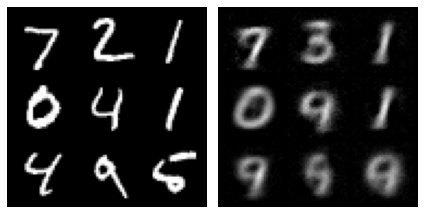

norm_swish custom 0.001 64 2
[ 32 784  11 | norm_swish         | normal          | custom          | PRE] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▇▆█◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▆▆▇▇█◂] | μ: [-0.017, -0.032, -0.052,  0.016, -0.005,  0.021, -0.032,  0.063,  0.034,  0.001,  0.035,  0.106,  0.116,  0.257,  0.362,  0.351,  0.464,  0.742,  0.956,  0.887,  1.505] σ: [ 0.992,  0.993,  0.992,  0.995,  1.007,  1.035,  1.108,  1.189,  1.177,  1.242,  1.411,  1.454,  1.848,  2.434,  3.026,  3.339,  4.196,  5.347,  6.266,  6.638,  9.241]
[ 32 784  11 | norm_swish         | normal          | custom          | AFT] - μ: [▸▄▃▂▃▂▂▂▄▁▁▁▃▁▂▂▂ ▂▃▂▄◂] σ: [▸▄▃▃▃▃▂▂▂▂▂▂▃▃▃▃▃▃▄▅▄▆◂] | μ: [ 0.014, -0.103, -0.181, -0.070, -0.137, -0.126, -0.188, -0.003, -0.232, -0.211, -0.260, -0.095, -0.282, -0.188, -0.205, -0.196, -0.328, -0.169, -0.064, -0.133, -0.036] σ: [ 0.952,  0.913,  0.880,  0.856,  0.820,  0.800,  0.797,  0.808,  0.748,  0.746,  0.739,  0.826,  0.842,  0.899,  0.912,  0.829,  0.847,  1.004,  1.064,  1.010,  1.189]
[ 32 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


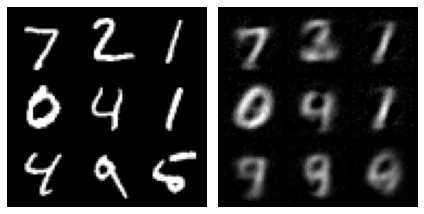

relu custom 0.001 64 2
[ 32 784  11 | relu               | normal          | custom          | PRE] - μ: [▸█▇▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▂▁▁▁▁               ◂] | μ: [ 0.399,  0.261,  0.211,  0.137,  0.126,  0.102,  0.068,  0.043,  0.033,  0.023,  0.018,  0.011,  0.011,  0.007,  0.004,  0.003,  0.002,  0.001,  0.001,  0.001,  0.000] σ: [ 0.584,  0.397,  0.294,  0.201,  0.175,  0.144,  0.109,  0.062,  0.048,  0.040,  0.024,  0.017,  0.013,  0.010,  0.007,  0.005,  0.003,  0.002,  0.001,  0.001,  0.001]
[ 32 784  11 | relu               | normal          | custom          | AFT] - μ: [▸█▇▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▂▂▁▁▁▁               ◂] | μ: [ 0.399,  0.261,  0.211,  0.137,  0.126,  0.102,  0.068,  0.043,  0.033,  0.023,  0.018,  0.011,  0.011,  0.007,  0.004,  0.003,  0.002,  0.001,  0.001,  0.001,  0.000] σ: [ 0.584,  0.397,  0.294,  0.201,  0.175,  0.144,  0.109,  0.062,  0.048,  0.040,  0.024,  0.017,  0.013,  0.010,  0.007,  0.005,  0.003,  0.002,  0.001,  0.001,  0.001]
[ 32 784  1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


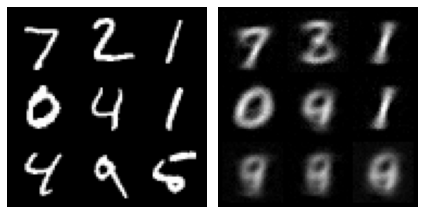

norm_relu custom 0.001 64 2
[ 32 784  11 | norm_relu          | normal          | custom          | PRE] - μ: [▸▃▃▄▄▃▃▄▄▂▂▂▃▃▂▃▅▅▄█▆▇◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▆▆▇▇█◂] | μ: [-0.027, -0.023, -0.005, -0.003, -0.045, -0.049, -0.007, -0.004, -0.069, -0.090, -0.080, -0.046, -0.033, -0.063, -0.051,  0.023,  0.056, -0.007,  0.149,  0.087,  0.126] σ: [ 0.946,  0.964,  0.982,  1.010,  0.972,  0.990,  0.993,  1.060,  1.032,  0.997,  1.028,  1.109,  1.109,  1.120,  1.142,  1.336,  1.494,  1.676,  1.954,  2.057,  2.315]
[ 32 784  11 | norm_relu          | normal          | custom          | AFT] - μ: [▸▃▃▄▃▄▂ ▅▃▁▃▃▄▄▄▄▄▄▄▄▄◂] σ: [▸▄▄▄▄▄▄▄▅▄▄▄▅▄▄▄▄▅▅▅▅▅◂] | μ: [-0.076, -0.043, -0.019, -0.076, -0.023, -0.116, -0.207,  0.039, -0.041, -0.134, -0.046, -0.045,  0.004,  0.004, -0.003, -0.013, -0.009,  0.010,  0.008,  0.015,  0.017] σ: [ 0.947,  0.967,  0.980,  1.003,  0.955,  0.962,  0.979,  1.081,  1.028,  0.994,  1.003,  1.064,  1.056,  1.021,  0.977,  1.046,  1.066,  1.074,  1.118,  1.085,  1.105]
[ 32 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


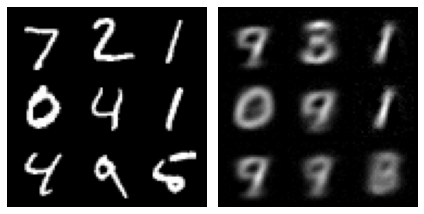

tanh xavier_uniform 0.001 64 2
[ 32 784  11 | tanh               | normal          | xavier_uniform  | PRE] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▁▁▁▁▁▁▁▁▁▁         ◂] | μ: [ 0.000,  0.000, -0.000,  0.000, -0.001,  0.000,  0.000, -0.000,  0.000,  0.000, -0.000, -0.000, -0.000,  0.000,  0.000,  0.000,  0.000, -0.000, -0.000, -0.000,  0.000] σ: [ 0.702,  0.527,  0.439,  0.386,  0.356,  0.319,  0.304,  0.285,  0.270,  0.267,  0.256,  0.230,  0.210,  0.189,  0.163,  0.144,  0.136,  0.128,  0.119,  0.110,  0.112]
[ 32 784  11 | tanh               | normal          | xavier_uniform  | AFT] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▁▁▁▁▁▁▁▁▁▁         ◂] | μ: [ 0.000,  0.000, -0.000,  0.000, -0.000,  0.000,  0.000,  0.000,  0.000, -0.000,  0.000,  0.000, -0.000,  0.000, -0.000, -0.000,  0.000,  0.000,  0.000, -0.000, -0.000] σ: [ 0.702,  0.527,  0.439,  0.386,  0.356,  0.320,  0.304,  0.285,  0.269,  0.266,  0.256,  0.230,  0.210,  0.189,  0.163,  0.144,  0.136,  0.128,  0.119,  0.109,  0.112]
[ 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


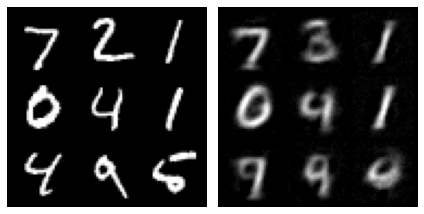

norm_tanh xavier_uniform 0.001 64 2
[ 32 784  11 | norm_tanh          | normal          | xavier_uniform  | PRE] - μ: [▸▆▃▅▄▁▆▅▇▃▄█▁▇▅▁▃▅▄▄▃▂◂] σ: [▸▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] | μ: [ 0.039, -0.013,  0.010, -0.007, -0.062,  0.032,  0.021,  0.056, -0.016,  0.002,  0.076, -0.058,  0.052,  0.021, -0.054, -0.025,  0.012, -0.003,  0.008, -0.021, -0.040] σ: [ 1.117,  1.059,  1.037,  1.042,  1.030,  1.016,  1.045,  1.045,  1.036,  1.016,  1.048,  1.020,  0.975,  0.962,  0.989,  0.987,  0.991,  0.981,  0.976,  0.979,  0.990]
[ 32 784  11 | norm_tanh          | normal          | xavier_uniform  | AFT] - μ: [▸▄▄▄▄▄▄▄▄▄▅▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] | μ: [-0.001,  0.003, -0.000,  0.001, -0.000, -0.002, -0.002,  0.001, -0.006,  0.009,  0.001, -0.002,  0.001, -0.000, -0.002, -0.003,  0.000, -0.004, -0.000, -0.001, -0.003] σ: [ 1.000,  1.000,  1.000,  0.999,  0.999,  0.998,  1.000,  0.999,  1.000,  1.004,  1.004,  1.002,  0.999,  0.997,  0.997,  0.997,  0.996,  0.998,  0.999,  0.998,  1.000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


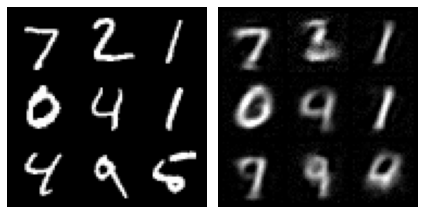

swish xavier_uniform 0.001 64 2
[ 32 784  11 | swish              | normal          | xavier_uniform  | PRE] - μ: [▸█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▁▁                 ◂] | μ: [ 0.323,  0.157,  0.062,  0.021,  0.014,  0.002,  0.002,  0.000,  0.000, -0.000, -0.000, -0.000,  0.000, -0.000, -0.000, -0.000,  0.000, -0.000,  0.000,  0.000, -0.000] σ: [ 0.753,  0.464,  0.267,  0.144,  0.074,  0.036,  0.019,  0.010,  0.005,  0.003,  0.002,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784  11 | swish              | normal          | xavier_uniform  | AFT] - μ: [▸█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▁▁                 ◂] | μ: [ 0.322,  0.156,  0.062,  0.021,  0.014,  0.002,  0.002,  0.000,  0.000, -0.000, -0.000, -0.000,  0.000, -0.000, -0.000, -0.000,  0.000, -0.000,  0.000,  0.000, -0.000] σ: [ 0.752,  0.464,  0.267,  0.144,  0.073,  0.036,  0.019,  0.010,  0.005,  0.003,  0.002,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


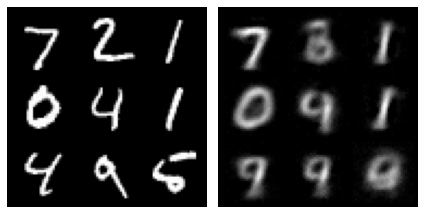

norm_swish xavier_uniform 0.001 64 2
[ 32 784  11 | norm_swish         | normal          | xavier_uniform  | PRE] - μ: [▸▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▅▅▆▆▇█◂] σ: [▸▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇█◂] | μ: [ 0.195,  0.267,  0.271,  0.435,  0.516,  0.666,  0.935,  1.401,  1.625,  2.389,  3.267,  3.104,  3.557,  4.112,  6.199,  5.616,  5.618,  8.158,  9.309, 10.494, 15.088] σ: [ 1.315,  1.428,  1.548,  1.734,  1.921,  2.189,  2.697,  3.795,  4.890,  5.800,  6.757,  7.454,  8.602, 10.002, 13.934, 13.398, 13.458, 17.895, 20.953, 25.932, 32.867]
[ 32 784  11 | norm_swish         | normal          | xavier_uniform  | AFT] - μ: [▸▇▆▄▅▄▄▂▅▃▃▃▂▃▁▂▂▁ ▁▃▃◂] σ: [▸▅▅▅▅▄▄▄▅▅▅▆▅▅▅▆▅▅▆▆▇█◂] | μ: [ 0.136,  0.090,  0.015,  0.060,  0.012, -0.012, -0.075,  0.029, -0.040, -0.036, -0.042, -0.102, -0.056, -0.142, -0.094, -0.097, -0.132, -0.184, -0.135, -0.043, -0.054] σ: [ 1.207,  1.183,  1.145,  1.130,  1.090,  1.046,  1.019,  1.124,  1.199,  1.272,  1.335,  1.281,  1.294,  1.311,  1.500,  1.321,  1.221,  1.379,  1.445,  1.597,  1.86

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


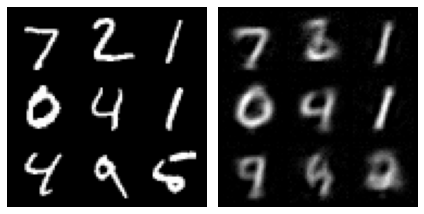

relu xavier_uniform 0.001 64 2
[ 32 784  11 | relu               | normal          | xavier_uniform  | PRE] - μ: [▸█▇▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▂▁▁▁▁              ◂] | μ: [ 0.523,  0.391,  0.295,  0.247,  0.158,  0.103,  0.087,  0.062,  0.050,  0.041,  0.026,  0.014,  0.011,  0.006,  0.004,  0.002,  0.001,  0.001,  0.000,  0.000,  0.000] σ: [ 0.766,  0.560,  0.427,  0.363,  0.246,  0.162,  0.127,  0.092,  0.065,  0.061,  0.038,  0.027,  0.015,  0.008,  0.005,  0.004,  0.002,  0.002,  0.001,  0.001,  0.000]
[ 32 784  11 | relu               | normal          | xavier_uniform  | AFT] - μ: [▸█▇▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▂▁▁▁▁              ◂] | μ: [ 0.523,  0.391,  0.295,  0.247,  0.158,  0.103,  0.087,  0.062,  0.050,  0.041,  0.026,  0.014,  0.011,  0.006,  0.004,  0.002,  0.001,  0.001,  0.000,  0.000,  0.000] σ: [ 0.766,  0.560,  0.427,  0.363,  0.246,  0.162,  0.127,  0.092,  0.065,  0.061,  0.038,  0.027,  0.015,  0.008,  0.005,  0.004,  0.002,  0.002,  0.001,  0.001,  0.000]
[ 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


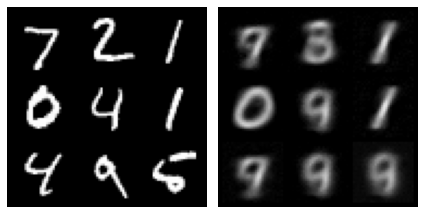

norm_relu xavier_uniform 0.001 64 2
[ 32 784  11 | norm_relu          | normal          | xavier_uniform  | PRE] - μ: [▸▅▅▅▅▆▆▆▆▇▆▇▆▇▇▇▇▇▇███◂] σ: [▸▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▇▇▇██◂] | μ: [ 0.289,  0.251,  0.220,  0.260,  0.353,  0.396,  0.444,  0.413,  0.587,  0.397,  0.667,  0.545,  0.692,  0.633,  0.606,  0.632,  0.629,  0.655,  0.844,  0.931,  0.888] σ: [ 1.413,  1.384,  1.411,  1.458,  1.556,  1.606,  1.749,  1.792,  2.094,  1.998,  2.377,  2.142,  2.536,  2.659,  2.502,  2.628,  2.817,  2.840,  3.320,  3.690,  3.787]
[ 32 784  11 | norm_relu          | normal          | xavier_uniform  | AFT] - μ: [▸█▆▅▄▅▄▄▄▄▄▄▃▁▁▃▁▂▃▃▃▄◂] σ: [▸▇▆▅▅▅▅▅▄▅▅▅▄▄▃▃▃▄▃▄▄▄◂] | μ: [ 0.194,  0.084,  0.031,  0.021,  0.057,  0.005,  0.012,  0.014, -0.015, -0.012, -0.008, -0.050, -0.143, -0.158, -0.045, -0.153, -0.100, -0.032, -0.068, -0.050, -0.016] σ: [ 1.315,  1.212,  1.154,  1.119,  1.124,  1.075,  1.089,  1.049,  1.104,  1.076,  1.166,  1.022,  0.945,  0.934,  0.925,  0.932,  0.948,  0.937,  0.973,  0.973,  0.949

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


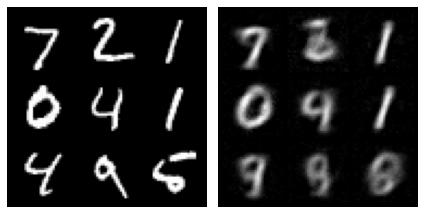

tanh xavier_normal 0.001 64 2
[ 32 784  11 | tanh               | normal          | xavier_normal   | PRE] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▁▁▁▁▁▁▁▁           ◂] | μ: [-0.000, -0.000,  0.000,  0.000,  0.000,  0.000, -0.000, -0.000,  0.000, -0.000, -0.000,  0.000,  0.000, -0.000,  0.000, -0.000,  0.000, -0.000,  0.000,  0.000, -0.000] σ: [ 0.702,  0.527,  0.440,  0.384,  0.342,  0.315,  0.299,  0.279,  0.267,  0.257,  0.240,  0.211,  0.199,  0.190,  0.187,  0.172,  0.170,  0.155,  0.151,  0.149,  0.136]
[ 32 784  11 | tanh               | normal          | xavier_normal   | AFT] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▁▁▁▁▁▁▁▁           ◂] | μ: [-0.000,  0.000,  0.000, -0.000,  0.000, -0.000,  0.000, -0.000,  0.000, -0.000, -0.000, -0.000,  0.000,  0.000,  0.000, -0.000, -0.000,  0.000, -0.000, -0.000, -0.000] σ: [ 0.702,  0.527,  0.440,  0.384,  0.342,  0.315,  0.299,  0.279,  0.267,  0.257,  0.240,  0.211,  0.199,  0.189,  0.186,  0.172,  0.170,  0.155,  0.151,  0.149,  0.136]
[ 32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


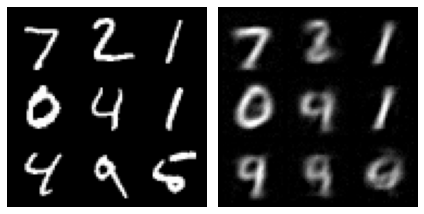

norm_tanh xavier_normal 0.001 64 2
[ 32 784  11 | norm_tanh          | normal          | xavier_normal   | PRE] - μ: [▸▅▄▅▆▂▂▁▇▆▅▃▅▄▅▄▄▆▃▄▆ ◂] σ: [▸▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄◂] | μ: [ 0.016,  0.005,  0.029,  0.037, -0.035, -0.035, -0.067,  0.062,  0.052,  0.022, -0.013,  0.021,  0.004,  0.024,  0.001, -0.009,  0.040, -0.029, -0.001,  0.042, -0.087] σ: [ 1.134,  1.068,  1.033,  1.020,  1.009,  1.024,  1.016,  1.020,  1.045,  1.053,  1.030,  0.972,  0.972,  0.952,  0.937,  0.943,  0.948,  0.968,  0.976,  0.951,  0.963]
[ 32 784  11 | norm_tanh          | normal          | xavier_normal   | AFT] - μ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] | μ: [-0.002, -0.001, -0.003,  0.002, -0.003,  0.005, -0.001, -0.002,  0.001, -0.002, -0.001,  0.001,  0.001,  0.003, -0.001, -0.001,  0.001,  0.006, -0.003, -0.001,  0.000] σ: [ 1.000,  1.000,  1.000,  0.999,  1.000,  1.001,  0.999,  0.999,  0.999,  1.001,  1.002,  0.999,  0.999,  0.999,  0.998,  0.998,  0.999,  1.000,  0.998,  0.999,  0.998]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


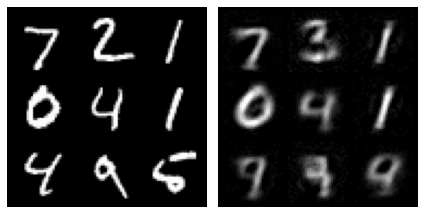

swish xavier_normal 0.001 64 2
[ 32 784  11 | swish              | normal          | xavier_normal   | PRE] - μ: [▸█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▁▁                 ◂] | μ: [ 0.323,  0.122,  0.042,  0.018,  0.008, -0.001,  0.001, -0.001,  0.000, -0.000, -0.000, -0.000, -0.000,  0.000,  0.000, -0.000, -0.000,  0.000,  0.000,  0.000,  0.000] σ: [ 0.754,  0.444,  0.245,  0.134,  0.070,  0.038,  0.020,  0.010,  0.006,  0.003,  0.001,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 32 784  11 | swish              | normal          | xavier_normal   | AFT] - μ: [▸█▆▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▁▁                 ◂] | μ: [ 0.323,  0.122,  0.042,  0.018,  0.008, -0.001,  0.001, -0.001,  0.000, -0.000, -0.000, -0.000, -0.000,  0.000,  0.000, -0.000, -0.000,  0.000,  0.000,  0.000,  0.000] σ: [ 0.754,  0.444,  0.245,  0.134,  0.070,  0.038,  0.020,  0.010,  0.006,  0.003,  0.001,  0.001,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000]
[ 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


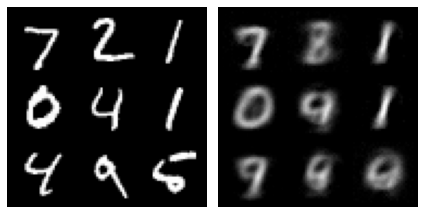

norm_swish xavier_normal 0.001 64 2
[ 32 784  11 | norm_swish         | normal          | xavier_normal   | PRE] - μ: [▸▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇█◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇█◂] | μ: [ 0.137,  0.223,  0.258,  0.360,  0.421,  0.635,  0.915,  1.134,  1.793,  2.861,  4.503,  4.549,  6.642,  5.164,  7.238,  7.741,  9.630, 11.630, 14.364, 23.378, 27.427] σ: [ 1.227,  1.343,  1.446,  1.624,  1.814,  2.173,  2.686,  3.271,  4.328,  6.474,  9.736, 10.946, 14.837, 14.411, 17.507, 21.119, 24.755, 29.959, 37.182, 57.507, 67.797]
[ 32 784  11 | norm_swish         | normal          | xavier_normal   | AFT] - μ: [▸▅▅▄▄▆▃▄▄▃▂▅▃▅▃▄▄▃▄▅▆█◂] σ: [▸▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆██◂] | μ: [ 0.069,  0.061,  0.025,  0.007,  0.096, -0.069,  0.009, -0.022, -0.053, -0.095,  0.043, -0.041,  0.032, -0.056,  0.010, -0.007, -0.037, -0.003,  0.046,  0.116,  0.247] σ: [ 1.142,  1.140,  1.097,  1.087,  1.037,  1.047,  1.094,  1.106,  1.178,  1.392,  1.718,  1.673,  2.033,  1.776,  2.008,  2.128,  2.306,  2.536,  2.897,  4.046,  4.473

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


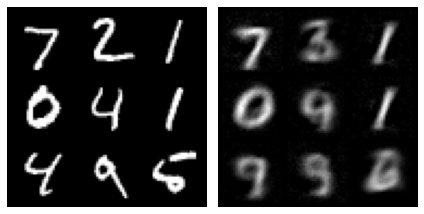

relu xavier_normal 0.001 64 2
[ 32 784  11 | relu               | normal          | xavier_normal   | PRE] - μ: [▸█▇▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▁▁▁▁               ◂] | μ: [ 0.522,  0.330,  0.242,  0.188,  0.139,  0.094,  0.077,  0.057,  0.044,  0.029,  0.018,  0.012,  0.007,  0.005,  0.004,  0.002,  0.001,  0.001,  0.001,  0.001,  0.000] σ: [ 0.765,  0.512,  0.366,  0.268,  0.192,  0.137,  0.113,  0.076,  0.073,  0.051,  0.033,  0.019,  0.012,  0.009,  0.005,  0.004,  0.002,  0.001,  0.001,  0.001,  0.001]
[ 32 784  11 | relu               | normal          | xavier_normal   | AFT] - μ: [▸█▇▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄◂] σ: [▸▃▂▁▁▁▁               ◂] | μ: [ 0.522,  0.330,  0.242,  0.188,  0.139,  0.094,  0.077,  0.057,  0.044,  0.029,  0.018,  0.012,  0.007,  0.005,  0.004,  0.002,  0.001,  0.001,  0.001,  0.001,  0.000] σ: [ 0.765,  0.512,  0.365,  0.268,  0.192,  0.137,  0.113,  0.076,  0.073,  0.051,  0.033,  0.019,  0.012,  0.009,  0.005,  0.004,  0.002,  0.001,  0.001,  0.001,  0.000]
[ 32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


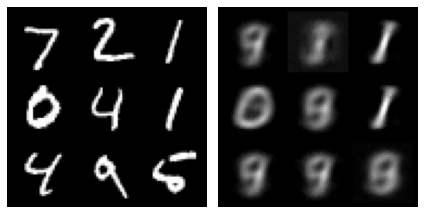

norm_relu xavier_normal 0.001 64 2
[ 32 784  11 | norm_relu          | normal          | xavier_normal   | PRE] - μ: [▸▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇██◂] σ: [▸▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇██◂] | μ: [ 0.200,  0.266,  0.363,  0.189,  0.340,  0.420,  0.581,  0.741,  0.874,  0.894,  1.036,  1.149,  1.270,  1.407,  1.656,  1.938,  2.240,  2.829,  3.254,  3.854,  3.804] σ: [ 1.281,  1.366,  1.522,  1.428,  1.575,  1.691,  1.857,  2.144,  2.647,  2.776,  3.542,  3.699,  3.883,  4.264,  4.747,  6.001,  6.779,  8.216,  9.653, 11.552, 11.614]
[ 32 784  11 | norm_relu          | normal          | xavier_normal   | AFT] - μ: [▸▆▇█▄▄▅▅▅▃▄▄▄▃▂▂▃▂▂▂▂▁◂] σ: [▸▆▆▆▅▅▅▅▅▆▅▆▅▅▅▄▅▅▅▆▆▅◂] | μ: [ 0.127,  0.172,  0.267, -0.008, -0.020,  0.078,  0.071,  0.051, -0.042, -0.031,  0.015, -0.022, -0.082, -0.113, -0.136, -0.089, -0.112, -0.132, -0.107, -0.129, -0.193] σ: [ 1.209,  1.206,  1.253,  1.117,  1.148,  1.160,  1.149,  1.152,  1.197,  1.165,  1.243,  1.186,  1.075,  1.076,  1.046,  1.105,  1.113,  1.165,  1.215,  1.251,  1.171]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


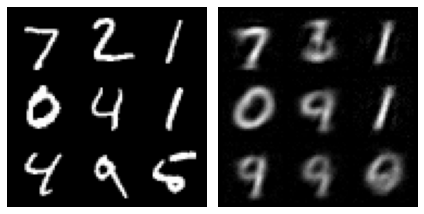

In [ ]:
# QUESTION: why is norm + default init so good? I thought custom/xavier_normal would have been good?

for init in ['default', 'custom', 'xavier_normal']:
    for act in ['tanh', 'norm_tanh', 'swish', 'norm_swish']:
        run(act, init, hidden_sizes(128, 32, r=10), batch_size=64, lr=1e-3, epochs=2, loss='mse');

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


norm_swish none default 0.001 128 5
warning, no init logic for layer of type: <class 'torch.nn.modules.container.ModuleList'>
warning, no init logic for layer of type: <class '__main__.SimpleLayers'>


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  if sys.path[0] == '':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


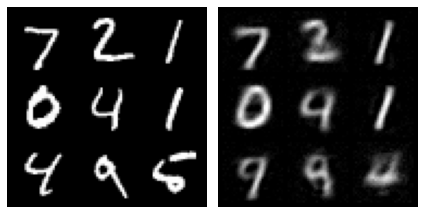

swish none default 0.001 128 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


warning, no init logic for layer of type: <class 'torch.nn.modules.container.ModuleList'>
warning, no init logic for layer of type: <class '__main__.SimpleLayers'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


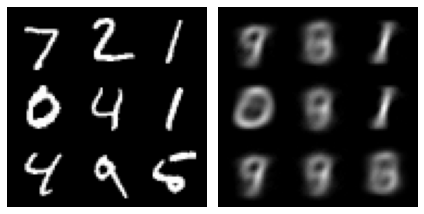

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


norm_swish none custom 0.001 128 5
warning, no init logic for layer of type: <class 'torch.nn.modules.container.ModuleList'>
warning, no init logic for layer of type: <class '__main__.SimpleLayers'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


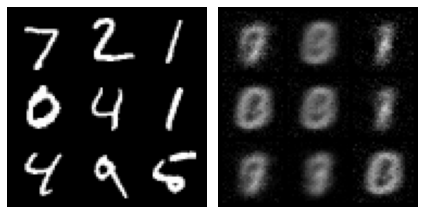

GPU available: False, used: False


swish none custom 0.001 128 5
warning, no init logic for layer of type: <class 'torch.nn.modules.container.ModuleList'>
warning, no init logic for layer of type: <class '__main__.SimpleLayers'>


TPU available: False, using: 0 TPU cores


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


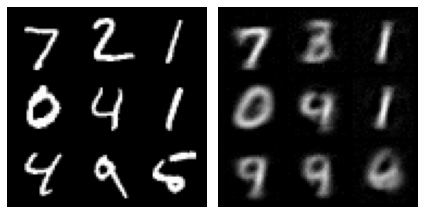

norm_swish none xavier_uniform 0.001 128 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


warning, no init logic for layer of type: <class 'torch.nn.modules.container.ModuleList'>
warning, no init logic for layer of type: <class '__main__.SimpleLayers'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


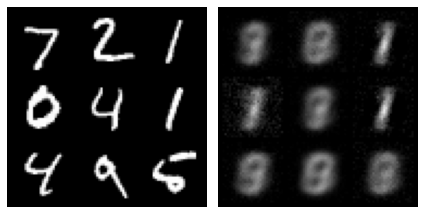

swish none xavier_uniform 0.001 128 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


warning, no init logic for layer of type: <class 'torch.nn.modules.container.ModuleList'>
warning, no init logic for layer of type: <class '__main__.SimpleLayers'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


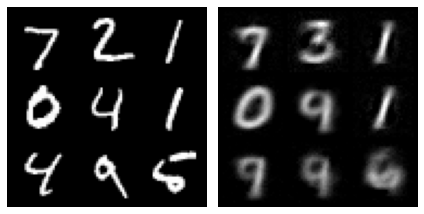

norm_swish none xavier_normal 0.001 128 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


warning, no init logic for layer of type: <class 'torch.nn.modules.container.ModuleList'>
warning, no init logic for layer of type: <class '__main__.SimpleLayers'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


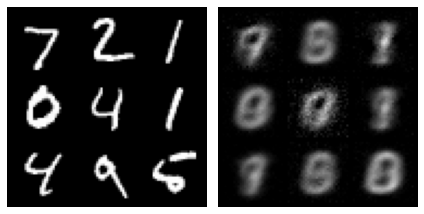

swish none xavier_normal 0.001 128 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


warning, no init logic for layer of type: <class 'torch.nn.modules.container.ModuleList'>
warning, no init logic for layer of type: <class '__main__.SimpleLayers'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


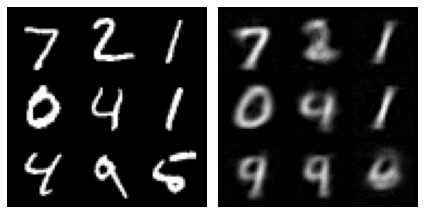

In [ ]:
# QUESTION: why is norm + default init so good? I thought custom/xavier_normal would have been good?

for init in ['default', 'custom', 'xavier_uniform', 'xavier_normal']:
    for act in ['norm_swish', 'swish']:
        run(act, 'none', init, hidden_sizes=hidden_sizes(128, 32, r=10), batch_size=128, lr=1e-3, epochs=5, loss='mse');

**RESULTS**

- norm generally scales loss too much at the start. Might be better to design scale values based on gradient rather than forward propagation.

- why is norm + default init so good? I thought custom/xavier_normal would have been good?